# EMAT30008 Scientific Computing

Michael Johnson - fr19042@bristol.ac.uk - 1962648

## Introduction

In this report, we will be show casing the capabilities of code written for this unit to solve ODEs and PDEs as well as discussing the design choices and learning process that went along with this project.

## Summary of Software

The software consists of four modules: 
1) integrate: contains solve_to function for integrating ODEs
2) BVP: contains shooting and solve_BVP
3) continuation: contains continuation for solving ODE equilibria/period orbits for varying parameters.
4) PDEs : Contains diffusion_solver for solving the diffusion-reaction equation.

Let's start by importing the required libraries.

In [1]:

from matplotlib.animation import FuncAnimation 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from scipy.optimize import root
%matplotlib inline

The summary of the software should explain the capabilities of your software (e.g., what methods are implemented — there is no need to explain how the methods work) and provide some examples, with results, of it in use. Code samples may be appropriate but they should be short and for the purpose of demonstration only.

- solve_to
    -> solving ODE problems
    -> RK4, forward euler
    -> error func thingy?
- continuation
    -> equilibria as parameter varies
    -> limit cycle as parameter varies
    -> bratu problem 

#### ODE integration methods

-> solve_to function
-> euler
-> runge-kutta
-> error func

The solve_to function calls euler_step or runge-kutta depending on user input to solve an ODE over a time span. Requires the user to choose an ODE, initial condition and time-range. Optional arguments include parameters, deltat_max and method.

We can perform a simple demonstration for two ODEs as outlined in the table below. The code is shown handling different solution dimensions, time spans and parameters.


|                     | ODE Equation                                                                           | True Solution                       |
|------------------  |----------------------------------------------------------------------------------------|-------------------------------------|
|                    | $x'(t) = x(t)$                                                                         | $ x(t) = x_{0}e^{t} $                        |
| Hopf Normal Form:  | $\frac{du_1}{dt} = \beta u_1 - u_2 + \sigma u_1(u_1^2 + u_2^2)$<br/>$\frac{du_2}{dt} = u_1 + \beta u_2 + \sigma u_2(u_1^2 + u_2^2)$ | $u_1(t) = \sqrt{\beta} \cos(t+\theta)$<br/>$u_2(t) = \sqrt{\beta} \sin(t+\theta)$ |



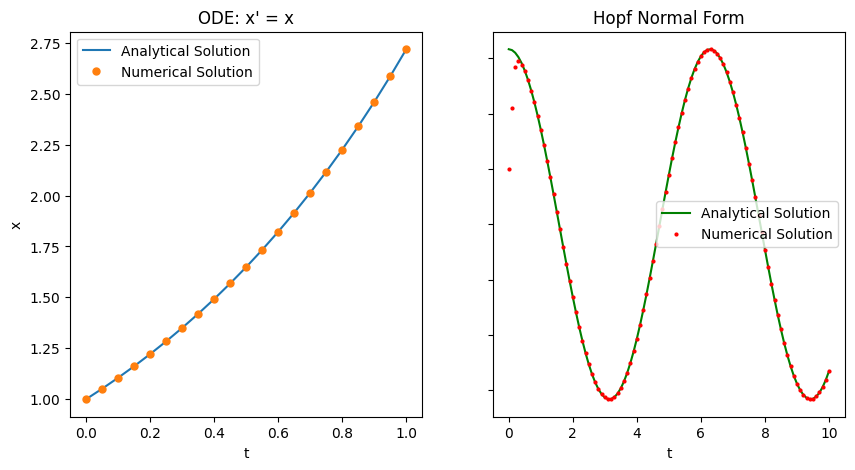

In [76]:
from integrate import solve_to
from functions import f

result = solve_to(func = f,x0 = [1],t = [0,1],parameters = None,deltat_max = 0.05,method = 'RK4')
x = result.x[0]
t = result.t_space

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(t,np.exp(t), label = 'Analytical Solution')
axs[0].plot(t,x,'o',markersize = 5,label = 'Numerical Solution')
axs[0].set_title("ODE: x' = x")
axs[0].set(xlabel='t', ylabel='x')
axs[0].legend(loc="best")

from functions import hopf_normal_form, hopf_normal_form_sol

beta = 10
result = solve_to(func=hopf_normal_form, x0=[0, 1], t=[0, 10], parameters=[beta, -1], deltat_max=0.1, method='RK4')
x = result.x[1]
t = result.t_space

axs[1].plot(t, hopf_normal_form_sol(t, beta, 0)[1], color='green', label='Analytical Solution')
axs[1].plot(t, x, 'o', color='red', markersize=2, label='Numerical Solution')
axs[1].set_title("Hopf Normal Form")
axs[1].set(xlabel='t', ylabel='x')
axs[1].legend(loc="best")


for ax in axs.flat:
    ax.label_outer()

#### ODE BVP solvers

-> shooting
-> finite difference

#### Continuation

continuation(myode, x0, par0, vary_par, step_size, max_steps, solve_for, method, solver) performs numerical continuation to solve some function, myode, given a varying parameter.

Allows user to choose a varying parameter based on its index in the parameters argument as part of chosen function = myode(x,t,parameters). User can choose between 'nParam' for natural parameter continuation or 'pArclength' for pseudo-arclength continuation. We will see in an example how natural parameter continuation fails against the analytical solution.

We will now demonstrate continuation used for solving equilibria of a basic ODE as well as isolating limit cycles in the predator prey model and varying mu in the Bratu diffusion reaction equation.

|                     | ODE Equation                                                                                      |
|---------------------|---------------------------------------------------------------------------------------------------|
|                     | ${\dot{x}}^3 - x + \alpha = 0$                                                                     |
| Predator-Prey Model | $\dot{x} = x(1 - x) - \frac{axy}{d + x}$<br/>$\dot{y} = by\left(1 - \frac{x}{y}\right)$          |
| Bratu Problem       | $D\frac{d^2u}{dx^2} + e^{\mu u} = 0,\, u(0) = u(1) = 0$                                            |


[Text(0.5, 0, 'mu'), Text(0, 0.5, 'u')]

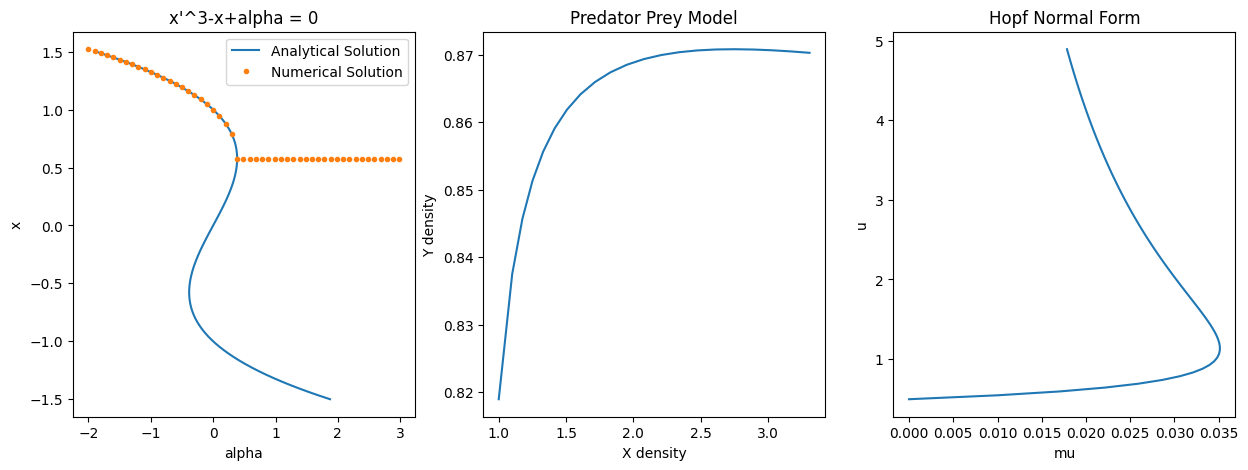

In [87]:
from continuation import continuation
from functions import bratu, h, PPM
from PDEs import Grid, BoundaryCondition, construct_A_and_b

y = np.linspace(-1.5,1.5,100)

u = continuation(h,x0 = [1],par0 = [-2],
                   vary_par = 0,
                   step_size = 0.1,
                   max_steps = 50,
                   solve_for = 'equilibria',
                   method = 'nParam')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(y-y**3,y, label = 'Analytical Solution')
axs[0].plot(u[-1],u[0],'o',markersize = 3, label = 'Numerical Solution')
axs[0].set_title("x'^3-x+alpha = 0")
axs[0].set(xlabel='alpha', ylabel='x')
axs[0].legend(loc="best")

u = continuation(PPM,x0 = [0.5,0.5,20],par0 = [1,0.1,0.1],
                   vary_par = 0,
                   step_size = 0.1,
                   max_steps = 20,
                   solve_for = 'limit_cycle',
                   method = 'pArclength')

axs[1].plot(u[-1],u[0])
axs[1].set_title("Predator Prey Model")
axs[1].set(xlabel='X density', ylabel='Y density')

grid = Grid(N=100, a=0, b=10)
bc_left = BoundaryCondition('dirichlet', [lambda t: 5],grid);bc_right = BoundaryCondition('dirichlet',[lambda t: 10],grid)
A,b = construct_A_and_b(grid,bc_left,bc_right)
dx = grid.dx
u0 = np.zeros(len(grid.x[1:-1]))

u = continuation(bratu,  # the ODE to use
    x0 = u0,  # the initial state
    par0=[0,1,dx,A],  # the initial parameters
    vary_par=0,  # the index of the parameter to vary
    step_size=0.01,  # the size of the steps to take
    max_steps=100,  # the number of steps to take
    solve_for = 'equilibria', # 'equilibria' or 'limit cycle'
    method = 'pArclength',
    solver=root)

axs[2].plot(u[-1],u[0])
axs[2].set_title("Hopf Normal Form")
axs[2].set(xlabel='mu', ylabel='u')





#### PDE Integration methods

-> explicit: euler + method of lines
-> implicit: euler + crank-nicolson
-> IMEX method
-> other features: sparse matrix, boundary conditions, initial conditions, source term

All PDE 

In [ ]:
from PDEs import Grid, BoundaryCondition, diffusion_solver, construct_A_and_b



## Key Software Decisions (40% of report mark)

The key design decisions should be described; explain your thinking behind the overall structure and interfaces of your code. 
If your code structure is intricate, a block diagram might be appropriate. 
Why were the solvers implemented as they are? 
What alternative designs might have been appropriate and why were they not pursued?

things to talk about:

why did i make the output a class in solve_to function?

why all results are from t=0

why combine ODEs into a single py file?

first two arguments of ODEs to solve must be x,t even when autonomous

way of setting up PDE solver means user needs to use BoundaryCondition, Grid functions

choose from RK4 and euler using string (user can't choose their own stepping function)



## Reflective learning log (30% of report mark)

What did I learn about the mathematical algorithms? I.e., solving boundary value problems, numerical ill-conditioning, etc.

What did I learn about software engineering? How have I progressed in my abilities?

What are the short-term implications of what I've learnt? (When will it be useful?)

What are the long-term implications of what I've learnt? (When will it be useful?)

What would I have done differently if I started the unit over again?

What will I do differently in the future?